# Spending Regression

In [1]:
# import packages
import sklearn
import numpy as np
import pandas as pd
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import ensemble
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(16)

In [2]:
df = pd.read_csv("regression_df.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102233 entries, 0 to 102232
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               102233 non-null  int64  
 1   customer_id              102233 non-null  int64  
 2   statement_mean           102233 non-null  float64
 3   statement_max            102233 non-null  float64
 4   avg_daily_transactions   80185 non-null   float64
 5   transaction1_mean        100651 non-null  float64
 6   transaction1_max         100651 non-null  float64
 7   transaction2_mean        101082 non-null  float64
 8   transaction2_max         101082 non-null  float64
 9   online_trans_percent     101082 non-null  float64
 10  transaction_food_mean    88271 non-null   float64
 11  transaction_food_max     88271 non-null   float64
 12  transaction_health_mean  53881 non-null   float64
 13  transaction_health_max   53881 non-null   float64
 14  tran

In [4]:
df.drop(["Unnamed: 0", "customer_id"], axis = 1, inplace=True)

## Data exploration

In [5]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102233 entries, 0 to 102232
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   statement_mean           102233 non-null  float64
 1   statement_max            102233 non-null  float64
 2   avg_daily_transactions   80185 non-null   float64
 3   transaction1_mean        100651 non-null  float64
 4   transaction1_max         100651 non-null  float64
 5   transaction2_mean        101082 non-null  float64
 6   transaction2_max         101082 non-null  float64
 7   online_trans_percent     101082 non-null  float64
 8   transaction_food_mean    88271 non-null   float64
 9   transaction_food_max     88271 non-null   float64
 10  transaction_health_mean  53881 non-null   float64
 11  transaction_health_max   53881 non-null   float64
 12  transaction_gas_mean     58004 non-null   float64
 13  transaction_gas_max      58004 non-null   float64
 14  Cust

,statement_mean,statement_max,avg_daily_transactions,transaction1_mean,transaction1_max,transaction2_mean,transaction2_max,online_trans_percent,transaction_food_mean,transaction_food_max,...,transaction_gas_max,Cust_Segment,Gender,Marital_Status,Education_Lv,Job_Status,Income,Age,Years_w_Bank,Penalty_201506
0,179.460000,369.10,4.000000,118.062500,370.00,73.820000,169.33,0.000000,71.275000,169.33,...,NaN,BİREYSEL,0,EVLİ,ORTAOKUL,EMEKLİ,7770.0,69,19.0,1)RISKSIZ
1,459.045455,2901.14,9.250000,573.497333,2901.14,85.435203,1500.00,0.020270,32.421000,278.58,...,100.0,BİREYSEL,1,EVLİ,LİSE,ÜCRETLİ (ÖZEL),2000.0,46,19.0,1)RISKSIZ
2,3077.044167,4846.09,11.714286,741.538462,2000.00,69.044054,558.40,0.108108,35.580000,86.19,...,51.0,BİREYSEL,0,EVLİ,ÜNİVERSİTE,ÇALIŞAN EMEKLİ(ÜCRETLİ),4960.0,47,19.0,1)RISKSIZ
3,1130.805833,2781.36,5.545455,856.911765,2572.00,568.726250,3147.99,0.125000,NaN,NaN,...,NaN,BİREYSEL,1,EVLİ,LİSE,ÜCRETLI (KAMU),2400.0,57,19.0,1)RISKSIZ
4,1531.865000,2909.81,2.000000,748.461538,2600.00,194.113846,840.00,0.000000,33.576667,49.39,...,NaN,BİREYSEL,0,EVLİ,LİSE,ÜCRETLİ (ÖZEL),0.0,49,19.0,1)RISKSIZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102228,71.460000,71.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,BİREYSEL,1,EVLİ,İLKOKUL,ÜCRETLİ (ÖZEL),1500.0,56,0.0,1)RISKSIZ
102229,1585.170000,1585.17,NaN,NaN,NaN,84.587500,320.00,0.125000,40.000000,40.00,...,NaN,BİREYSEL,0,EVLİ,LİSE,ÜCRETLİ (ÖZEL),2000.0,33,0.0,1)RISKSIZ
102230,21.500000,21.50,NaN,NaN,NaN,10.750000,15.50,0.000000,6.000000,6.00,...,NaN,BİREYSEL,0,BEKAR,YÜKSEKOKUL,ÜCRETLİ (ÖZEL),1200.0,22,0.0,1)RISKSIZ
102231,34.750000,34.75,NaN,NaN,NaN,21.187500,34.75,0.000000,NaN,NaN,...,NaN,BİREYSEL,0,BEKAR,ÜNİVERSİTE,ÜCRETLİ (ÖZEL),2200.0,23,0.0,1)RISKSIZ


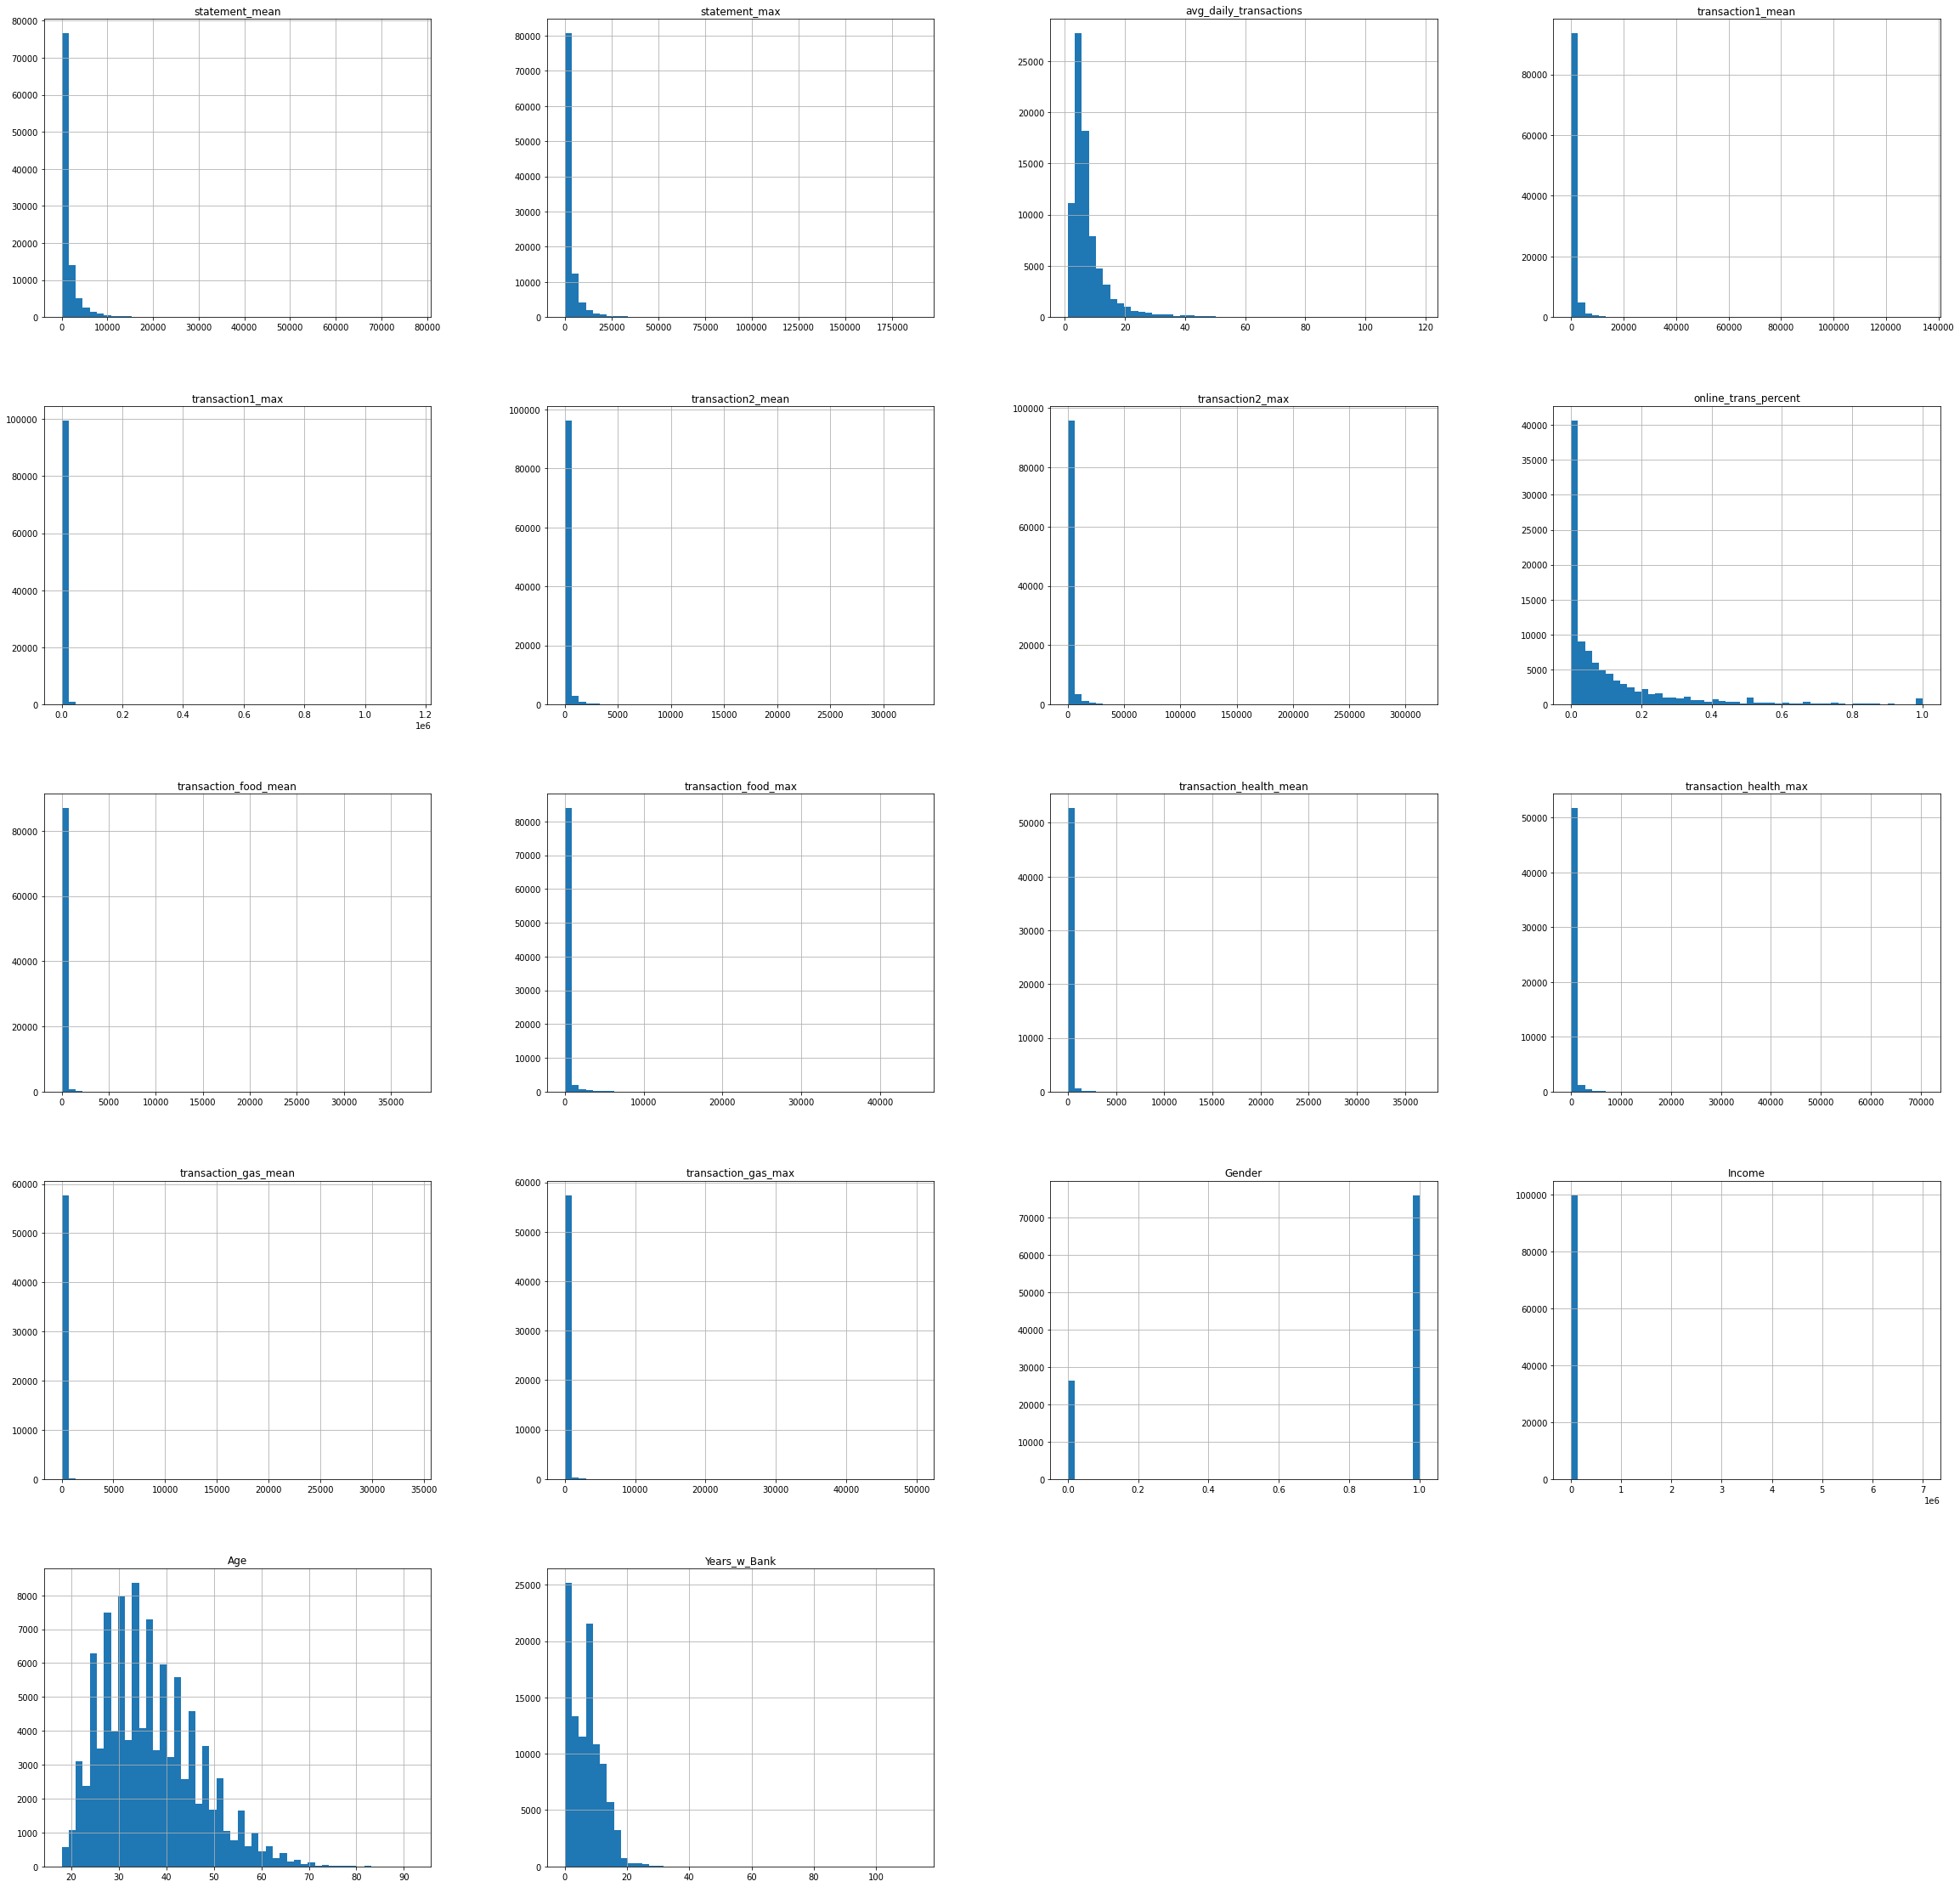

In [6]:
df.hist(bins=50, figsize=(40,40))
plt.show()

In [7]:
df["Marital_Status"].value_counts()

EVLİ                65045
BEKAR               30547
BOŞANMIŞ             4795
BİLINMİYOR           1388
DUL                   455
EVLİLİĞİN İPTALİ        3
Name: Marital_Status, dtype: int64

In [8]:
df["Cust_Segment"].value_counts()

BİREYSEL                       95571
BİREBİR                         3998
MİKRO                           2442
EXI26                            128
ÖZEL BANKACILIK MÜŞTERİLERİ       94
Name: Cust_Segment, dtype: int64

In [9]:
df["Gender"].value_counts()

1    75875
0    26358
Name: Gender, dtype: int64

In [10]:
df["Education_Lv"].value_counts() 

LİSE          46328
ÜNİVERSİTE    26668
ORTAOKUL       8636
YÜKSEKOKUL     8031
İLKOKUL        7475
LİSANSÜSTÜ     3511
EĞİTİMSİZ      1285
DOKTORA         217
BİLİNMİYOR       82
Name: Education_Lv, dtype: int64

In [11]:
df["Job_Status"].value_counts() 

ÜCRETLİ (ÖZEL)                    77948
SERBEST MESLEK                    10683
ÜCRETLI (KAMU)                     5320
EMEKLİ                             3381
ÇALIŞAN EMEKLİ(ÜCRETLİ)            1995
EV HANIMI                           781
ÇALIŞMIYOR                          696
ÇALIŞAN EMEKLİ(SERBEST MESLEK)      584
DİĞER                               453
TANIMSIZ                            220
ÖĞRENCİ                             161
YURTDIŞINDA ÇALIŞAN                   8
ÇOCUK (18 YAŞIN ALTINDA)              3
Name: Job_Status, dtype: int64

In [12]:
df.corr()

,statement_mean,statement_max,avg_daily_transactions,transaction1_mean,transaction1_max,transaction2_mean,transaction2_max,online_trans_percent,transaction_food_mean,transaction_food_max,transaction_health_mean,transaction_health_max,transaction_gas_mean,transaction_gas_max,Gender,Income,Age,Years_w_Bank
statement_mean,1.000000,0.888834,-0.025469,0.750342,0.494669,0.375929,0.548250,-0.024997,0.303853,0.401877,0.162188,0.265557,0.179830,0.205391,0.059845,0.067509,0.204553,0.254974
statement_max,0.888834,1.000000,-0.023162,0.789711,0.610992,0.403971,0.650777,-0.016384,0.280416,0.412444,0.183314,0.304012,0.199461,0.230604,0.066981,0.079597,0.224672,0.290913
avg_daily_transactions,-0.025469,-0.023162,1.000000,-0.023159,-0.005839,-0.033960,-0.023335,0.017048,-0.025339,-0.026690,-0.007006,-0.011788,-0.017817,-0.014710,-0.026596,-0.004555,-0.031872,0.007387
transaction1_mean,0.750342,0.789711,-0.023159,1.000000,0.771842,0.449728,0.686663,-0.023907,0.293597,0.388996,0.191331,0.349651,0.197883,0.221285,0.063006,0.076871,0.199890,0.238669
transaction1_max,0.494669,0.610992,-0.005839,0.771842,1.000000,0.339533,0.646670,0.003962,0.164221,0.265988,0.148006,0.298955,0.113535,0.137399,0.040044,0.057945,0.134507,0.171475
transaction2_mean,0.375929,0.403971,-0.033960,0.449728,0.339533,1.000000,0.480347,0.033393,0.657742,0.514623,0.401423,0.307912,0.369669,0.307337,0.050420,0.033999,0.115516,0.108200
transaction2_max,0.548250,0.650777,-0.023335,0.686663,0.646670,0.480347,1.000000,0.003376,0.243542,0.356008,0.214940,0.344214,0.171836,0.204117,0.060607,0.063987,0.176124,0.223059
online_trans_percent,-0.024997,-0.016384,0.017048,-0.023907,0.003962,0.033393,0.003376,1.000000,-0.005711,-0.030253,0.044136,0.022403,0.007999,-0.004456,-0.020563,0.004001,-0.124106,-0.026462
transaction_food_mean,0.303853,0.280416,-0.025339,0.293597,0.164221,0.657742,0.243542,-0.005711,1.000000,0.727496,0.280074,0.159385,0.080582,0.082811,0.042198,0.021534,0.055933,0.059419
transaction_food_max,0.401877,0.412444,-0.026690,0.388996,0.265988,0.514623,0.356008,-0.030253,0.727496,1.000000,0.177126,0.141523,0.077427,0.098493,0.055951,0.030192,0.078228,0.101096


In [13]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102233 entries, 0 to 102232
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   statement_mean           102233 non-null  float64
 1   statement_max            102233 non-null  float64
 2   avg_daily_transactions   80185 non-null   float64
 3   transaction1_mean        100651 non-null  float64
 4   transaction1_max         100651 non-null  float64
 5   transaction2_mean        101082 non-null  float64
 6   transaction2_max         101082 non-null  float64
 7   online_trans_percent     101082 non-null  float64
 8   transaction_food_mean    88271 non-null   float64
 9   transaction_food_max     88271 non-null   float64
 10  transaction_health_mean  53881 non-null   float64
 11  transaction_health_max   53881 non-null   float64
 12  transaction_gas_mean     58004 non-null   float64
 13  transaction_gas_max      58004 non-null   float64
 14  Cust

,statement_mean,statement_max,avg_daily_transactions,transaction1_mean,transaction1_max,transaction2_mean,transaction2_max,online_trans_percent,transaction_food_mean,transaction_food_max,transaction_health_mean,transaction_health_max,transaction_gas_mean,transaction_gas_max,Gender,Income,Age,Years_w_Bank
count,102233.00000,102233.000000,80185.000000,100651.000000,1.006510e+05,101082.000000,101082.000000,101082.000000,88271.000000,88271.000000,53881.000000,53881.000000,58004.000000,58004.000000,102233.000000,9.981700e+04,102233.000000,102228.000000
mean,1476.13836,3011.101212,7.908575,984.178130,2.813923e+03,201.824559,1696.120853,0.110303,92.480664,315.540458,118.608071,301.625349,96.618668,181.406289,0.742177,4.094056e+03,36.547358,7.045741
std,2600.22962,5197.667061,7.095393,1888.856946,8.363639e+03,543.775716,3945.793097,0.176041,422.664496,1178.287810,469.387824,1107.006648,335.595884,722.149061,0.437438,4.393701e+04,10.025304,5.091257
min,0.00000,0.000000,1.000000,0.010000,1.000000e-02,0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.000000,0.000000e+00,18.000000,0.000000
25%,343.12500,739.380000,4.000000,264.400000,6.000000e+02,53.905848,284.985000,0.000000,24.520000,60.000000,25.000000,35.000000,40.000000,50.000000,0.000000,1.200000e+03,29.000000,3.000000
50%,677.18000,1319.090000,5.833333,483.337100,1.100000e+03,89.049625,649.470000,0.041667,38.810000,115.000000,45.900000,79.000000,69.134035,100.000000,1.000000,2.000000e+03,35.000000,7.000000
75%,1544.76000,3175.710000,9.000000,993.060150,2.761035e+03,166.588925,1621.882500,0.138018,65.443945,219.065000,94.750000,210.000000,110.000000,200.000000,1.000000,3.356000e+03,43.000000,11.000000
max,77021.34000,187921.300000,118.000000,133914.200000,1.159152e+06,33105.330000,312600.000000,1.000000,37385.000000,44613.500000,36500.000000,70382.400000,34000.000000,50000.000000,1.000000,7.000000e+06,92.000000,113.000000


### Creating datasets for regression

In [14]:
df_trans1 = df[df['transaction1_mean'].notna()]
df_trans2 = df[df['transaction2_mean'].notna()]
df_food = df[df['transaction_food_mean'].notna()]
df_health = df[df['transaction_health_mean'].notna()]
df_gas = df[df['transaction_gas_mean'].notna()]

## Train/Test Split

In [15]:
#Statements
statement_train_set, statement_test_set = train_test_split(df, test_size=0.2, random_state=16)

# statement_predictors = statement_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506"]].copy() 
#Added "online_trans_percent","avg_daily_transactions"
statement_predictors = statement_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy() 
statement_mean_y = statement_train_set["statement_mean"].copy()
statement_max_y = statement_train_set["statement_max"].copy()

# statement_predictors_test = statement_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506"]].copy()
statement_predictors_test = statement_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
statement_mean_y_test = statement_test_set["statement_mean"].copy()
statement_max_y_test = statement_test_set["statement_max"].copy()


#Transactions1
trans1_train_set, trans1_test_set = train_test_split(df_trans1, test_size=0.2, random_state=16)

trans1_predictors = trans1_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans1_mean_y = trans1_train_set["transaction1_mean"].copy()
trans1_max_y = trans1_train_set["transaction1_max"].copy()

trans1_predictors_test = trans1_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans1_mean_y_test = trans1_test_set["transaction1_mean"].copy()
trans1_max_y_test = trans1_test_set["transaction1_max"].copy()

#Transactions2
trans2_train_set, trans2_test_set = train_test_split(df_trans2, test_size=0.2, random_state=16)

trans2_predictors = trans2_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans2_mean_y = trans2_train_set["transaction2_mean"].copy()
trans2_max_y = trans2_train_set["transaction2_max"].copy()

trans2_predictors_test = trans2_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans2_mean_y_test = trans2_test_set["transaction2_mean"].copy()
trans2_max_y_test = trans2_test_set["transaction2_max"].copy()

#Food Transactions
food_train_set, food_test_set = train_test_split(df_food, test_size=0.2, random_state=16)

food_predictors = food_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
food_mean_y = food_train_set["transaction_food_mean"].copy()
food_max_y = food_train_set["transaction_food_max"].copy()

food_predictors_test = food_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
food_mean_y_test = food_test_set["transaction_food_mean"].copy()
food_max_y_test = food_test_set["transaction_food_max"].copy()

#health Transactions
health_train_set, health_test_set = train_test_split(df_health, test_size=0.2, random_state=16)

health_predictors = health_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
health_mean_y = health_train_set["transaction_health_mean"].copy()
health_max_y = health_train_set["transaction_health_max"].copy()

health_predictors_test = health_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
health_mean_y_test = health_test_set["transaction_health_mean"].copy()
health_max_y_test = health_test_set["transaction_health_max"].copy()

#gas Transactions
gas_train_set, gas_test_set = train_test_split(df_gas, test_size=0.2, random_state=16)

gas_predictors = gas_train_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
gas_mean_y = gas_train_set["transaction_gas_mean"].copy()
gas_max_y = gas_train_set["transaction_gas_max"].copy()

gas_predictors_test = gas_test_set[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
gas_mean_y_test = gas_test_set["transaction_gas_mean"].copy()
gas_max_y_test = gas_test_set["transaction_gas_max"].copy()


## Transformation Pipelines

In [16]:
num_attribs = ["Income","Age","Years_w_Bank","online_trans_percent","avg_daily_transactions"] 
cat_attribs = ["Cust_Segment","Marital_Status","Education_Lv","Job_Status","Penalty_201506"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
])

In [17]:
statement_X = full_pipeline.fit_transform(statement_predictors)
statement_X_test = full_pipeline.transform(statement_predictors_test)

trans1_X = full_pipeline.fit_transform(trans1_predictors)
trans1_X_test = full_pipeline.transform(trans1_predictors_test)

trans2_X = full_pipeline.fit_transform(trans2_predictors)
trans2_X_test = full_pipeline.transform(trans2_predictors_test)

food_X = full_pipeline.fit_transform(food_predictors)
food_X_test = full_pipeline.transform(food_predictors_test)

health_X = full_pipeline.fit_transform(health_predictors)
health_X_test = full_pipeline.transform(health_predictors_test)

gas_X = full_pipeline.fit_transform(gas_predictors)
gas_X_test = full_pipeline.transform(gas_predictors_test)

## Regressions

### Basic Linear (baseline) models

In [18]:
#mean spending
lr_statement_mean = linear_model.LinearRegression()
lr_statement_mean.fit(statement_X, statement_mean_y)

lr_trans1_mean = linear_model.LinearRegression()
lr_trans1_mean.fit(trans1_X, trans1_mean_y)

lr_trans2_mean = linear_model.LinearRegression()
lr_trans2_mean.fit(trans2_X, trans2_mean_y)

lr_food_mean = linear_model.LinearRegression()
lr_food_mean.fit(food_X, food_mean_y)

lr_health_mean = linear_model.LinearRegression()
lr_health_mean.fit(health_X, health_mean_y)

lr_gas_mean = linear_model.LinearRegression()
lr_gas_mean.fit(gas_X, gas_mean_y)

#max spending
lr_statement_max = linear_model.LinearRegression()
lr_statement_max.fit(statement_X, statement_max_y)

lr_trans1_max = linear_model.LinearRegression()
lr_trans1_max.fit(trans1_X, trans1_max_y)

lr_trans2_max = linear_model.LinearRegression()
lr_trans2_max.fit(trans2_X, trans2_max_y)

lr_food_max = linear_model.LinearRegression()
lr_food_max.fit(food_X, food_max_y)

lr_health_max = linear_model.LinearRegression()
lr_health_max.fit(health_X, health_max_y)

lr_gas_max = linear_model.LinearRegression()
lr_gas_max.fit(gas_X, gas_max_y)

LinearRegression()

In [19]:
lr_statement_mean_predictions = lr_statement_mean.predict(statement_X_test)
lr_statement_max_predictions = lr_statement_max.predict(statement_X_test)

lr_trans1_mean_predictions = lr_trans1_mean.predict(trans1_X_test)
lr_trans1_max_predictions = lr_trans1_max.predict(trans1_X_test)

lr_trans2_mean_predictions = lr_trans2_mean.predict(trans2_X_test)
lr_trans2_max_predictions = lr_trans2_max.predict(trans2_X_test)

lr_food_mean_predictions = lr_food_mean.predict(food_X_test)
lr_food_max_predictions = lr_food_max.predict(food_X_test)

lr_health_mean_predictions = lr_health_mean.predict(health_X_test)
lr_health_max_predictions = lr_health_max.predict(health_X_test)

lr_gas_mean_predictions = lr_gas_mean.predict(gas_X_test)
lr_gas_max_predictions = lr_gas_max.predict(gas_X_test)


print("Mean Statements Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y_test, lr_statement_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_mean_y_test, lr_statement_mean_predictions), "\n")
print("Max Statements Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, lr_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, lr_statement_max_predictions), "\n")

print("Mean Transaction Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y_test, lr_trans1_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_mean_y_test, lr_trans1_mean_predictions), "\n")
print("Max Transaction Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y_test, lr_trans1_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_max_y_test, lr_trans1_max_predictions), "\n")

print("Mean Credit Card Payment Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y_test, lr_trans2_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_mean_y_test, lr_trans2_mean_predictions), "\n")
print("Max Credit Card Payment Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y_test, lr_trans2_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_max_y_test, lr_trans2_max_predictions), "\n")

print("Mean Food Transactions Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y_test, lr_food_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_mean_y_test, lr_food_mean_predictions), "\n")
print("Max Food Transactions Regression","\n", "RMSE: ", (mean_squared_error(food_max_y_test, lr_food_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_max_y_test, lr_food_max_predictions), "\n")

print("Mean Health Transactions Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y_test, lr_health_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_mean_y_test, lr_health_mean_predictions), "\n")
print("Max Health Transactions Regression","\n", "RMSE: ", (mean_squared_error(health_max_y_test, lr_health_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_max_y_test, lr_health_max_predictions), "\n")

print("Mean Gas Transactions Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y_test, lr_gas_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_mean_y_test, lr_gas_mean_predictions), "\n")
print("Max Gas Transactions Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y_test, lr_gas_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_max_y_test, lr_gas_max_predictions), "\n")

Mean Statements Regression 
 RMSE:  2343.1450223182683 
 R2:  0.24611412042401704 

Max Statements Regression 
 RMSE:  4415.775335832716 
 R2:  0.3035714949728203 

Mean Transaction Regression 
 RMSE:  1454.1518546267566 
 R2:  0.3192302286548332 

Max Transaction Regression 
 RMSE:  5021.612320990422 
 R2:  0.2587571271303296 

Mean Credit Card Payment Regression 
 RMSE:  569.0477851616993 
 R2:  0.06723799275574394 

Max Credit Card Payment Regression 
 RMSE:  3617.9881212852356 
 R2:  0.1941913071944692 

Mean Food Transactions Regression 
 RMSE:  394.1047538661073 
 R2:  0.03435020930263433 

Max Food Transactions Regression 
 RMSE:  1113.0246818289897 
 R2:  0.07350890085274775 

Mean Health Transactions Regression 
 RMSE:  544.346753220678 
 R2:  0.01913894480462308 

Max Health Transactions Regression 
 RMSE:  1246.786362714493 
 R2:  0.052885141473769215 

Mean Gas Transactions Regression 
 RMSE:  217.90075615776183 
 R2:  0.022272208318017905 

Max Gas Transactions Regression 

### Ridge Regression

In [20]:
#mean spending
ridge_statement_mean = linear_model.Ridge(alpha=.5)
ridge_statement_mean.fit(statement_X, statement_mean_y)

ridge_trans1_mean = linear_model.Ridge(alpha=.5)
ridge_trans1_mean.fit(trans1_X, trans1_mean_y)

ridge_trans2_mean = linear_model.Ridge(alpha=.5)
ridge_trans2_mean.fit(trans2_X, trans2_mean_y)

ridge_food_mean = linear_model.Ridge(alpha=.5)
ridge_food_mean.fit(food_X, food_mean_y)

ridge_health_mean = linear_model.Ridge(alpha=.5)
ridge_health_mean.fit(health_X, health_mean_y)

ridge_gas_mean = linear_model.Ridge(alpha=.5)
ridge_gas_mean.fit(gas_X, gas_mean_y)

#max spending
ridge_statement_max = linear_model.Ridge(alpha=.5)
ridge_statement_max.fit(statement_X, statement_max_y)

ridge_trans1_max = linear_model.Ridge(alpha=.5)
ridge_trans1_max.fit(trans1_X, trans1_max_y)

ridge_trans2_max = linear_model.Ridge(alpha=.5)
ridge_trans2_max.fit(trans2_X, trans2_max_y)

ridge_food_max = linear_model.Ridge(alpha=.5)
ridge_food_max.fit(food_X, food_max_y)

ridge_health_max = linear_model.Ridge(alpha=.5)
ridge_health_max.fit(health_X, health_max_y)

ridge_gas_max = linear_model.Ridge(alpha=.5)
ridge_gas_max.fit(gas_X, gas_max_y)

Ridge(alpha=0.5)

In [21]:
ridge_statement_mean_predictions = ridge_statement_mean.predict(statement_X_test)
ridge_statement_max_predictions = ridge_statement_max.predict(statement_X_test)

ridge_trans1_mean_predictions = ridge_trans1_mean.predict(trans1_X_test)
ridge_trans1_max_predictions = ridge_trans1_max.predict(trans1_X_test)

ridge_trans2_mean_predictions = ridge_trans2_mean.predict(trans2_X_test)
ridge_trans2_max_predictions = ridge_trans2_max.predict(trans2_X_test)

ridge_food_mean_predictions = ridge_food_mean.predict(food_X_test)
ridge_food_max_predictions = ridge_food_max.predict(food_X_test)

ridge_health_mean_predictions = ridge_health_mean.predict(health_X_test)
ridge_health_max_predictions = ridge_health_max.predict(health_X_test)

ridge_gas_mean_predictions = ridge_gas_mean.predict(gas_X_test)
ridge_gas_max_predictions = ridge_gas_max.predict(gas_X_test)


print("Mean Statements Ridge Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y_test, ridge_statement_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_mean_y_test, ridge_statement_mean_predictions), "\n")
print("Max Statements Ridge Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, ridge_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, ridge_statement_max_predictions), "\n")

print("Mean Transaction Ridge Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y_test, ridge_trans1_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_mean_y_test, ridge_trans1_mean_predictions), "\n")
print("Max Transaction Ridge Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y_test, ridge_trans1_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_max_y_test, ridge_trans1_max_predictions), "\n")

print("Mean Credit Card Payment Ridge Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y_test, ridge_trans2_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_mean_y_test, ridge_trans2_mean_predictions), "\n")
print("Max Credit Card Payment Ridge Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y_test, ridge_trans2_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_max_y_test, ridge_trans2_max_predictions), "\n")

print("Mean Food Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y_test, ridge_food_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_mean_y_test, ridge_food_mean_predictions), "\n")
print("Max Food Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(food_max_y_test, ridge_food_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_max_y_test, ridge_food_max_predictions), "\n")

print("Mean Health Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y_test, ridge_health_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_mean_y_test, ridge_health_mean_predictions), "\n")
print("Max Health Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(health_max_y_test, ridge_health_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_max_y_test, ridge_health_max_predictions), "\n")

print("Mean Gas Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y_test, ridge_gas_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_mean_y_test, ridge_gas_mean_predictions), "\n")
print("Max Gas Transactions Ridge Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y_test, ridge_gas_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_max_y_test, ridge_gas_max_predictions), "\n")

Mean Statements Ridge Regression 
 RMSE:  2342.64583118514 
 R2:  0.24643530674008374 

Max Statements Ridge Regression 
 RMSE:  4415.566253045051 
 R2:  0.3036374438741525 

Mean Transaction Ridge Regression 
 RMSE:  1454.144561718052 
 R2:  0.3192370570741977 

Max Transaction Ridge Regression 
 RMSE:  5021.723244600421 
 R2:  0.2587243797821901 

Mean Credit Card Payment Ridge Regression 
 RMSE:  569.0511103779585 
 R2:  0.06722709158176343 

Max Credit Card Payment Ridge Regression 
 RMSE:  3617.885340441162 
 R2:  0.19423708983300803 

Mean Food Transactions Ridge Regression 
 RMSE:  394.1038340655118 
 R2:  0.03435471675506807 

Max Food Transactions Ridge Regression 
 RMSE:  1112.988881906546 
 R2:  0.07356850020685779 

Mean Health Transactions Ridge Regression 
 RMSE:  544.3462469224421 
 R2:  0.019140769406269187 

Max Health Transactions Ridge Regression 
 RMSE:  1245.8030963001218 
 R2:  0.054378418977556686 

Mean Gas Transactions Ridge Regression 
 RMSE:  217.888494982616

### Lasso Regression

In [22]:
#mean spending
lasso_statement_mean = linear_model.Lasso(alpha=.5)
lasso_statement_mean.fit(statement_X, statement_mean_y)

lasso_trans1_mean = linear_model.Lasso(alpha=.5)
lasso_trans1_mean.fit(trans1_X, trans1_mean_y)

lasso_trans2_mean = linear_model.Lasso(alpha=.5)
lasso_trans2_mean.fit(trans2_X, trans2_mean_y)

lasso_food_mean = linear_model.Lasso(alpha=.5)
lasso_food_mean.fit(food_X, food_mean_y)

lasso_health_mean = linear_model.Lasso(alpha=.5)
lasso_health_mean.fit(health_X, health_mean_y)

lasso_gas_mean = linear_model.Lasso(alpha=.5)
lasso_gas_mean.fit(gas_X, gas_mean_y)

#max spending
lasso_statement_max = linear_model.Lasso(alpha=.5)
lasso_statement_max.fit(statement_X, statement_max_y)

lasso_trans1_max = linear_model.Lasso(alpha=.5)
lasso_trans1_max.fit(trans1_X, trans1_max_y)

lasso_trans2_max = linear_model.Lasso(alpha=.5)
lasso_trans2_max.fit(trans2_X, trans2_max_y)

lasso_food_max = linear_model.Lasso(alpha=.5)
lasso_food_max.fit(food_X, food_max_y)

lasso_health_max = linear_model.Lasso(alpha=.5)
lasso_health_max.fit(health_X, health_max_y)

lasso_gas_max = linear_model.Lasso(alpha=.5)
lasso_gas_max.fit(gas_X, gas_max_y)

Lasso(alpha=0.5)

In [23]:
lasso_statement_mean_predictions = lasso_statement_mean.predict(statement_X_test)
lasso_statement_max_predictions = lasso_statement_max.predict(statement_X_test)

lasso_trans1_mean_predictions = lasso_trans1_mean.predict(trans1_X_test)
lasso_trans1_max_predictions = lasso_trans1_max.predict(trans1_X_test)

lasso_trans2_mean_predictions = lasso_trans2_mean.predict(trans2_X_test)
lasso_trans2_max_predictions = lasso_trans2_max.predict(trans2_X_test)

lasso_food_mean_predictions = lasso_food_mean.predict(food_X_test)
lasso_food_max_predictions = lasso_food_max.predict(food_X_test)

lasso_health_mean_predictions = lasso_health_mean.predict(health_X_test)
lasso_health_max_predictions = lasso_health_max.predict(health_X_test)

lasso_gas_mean_predictions = lasso_gas_mean.predict(gas_X_test)
lasso_gas_max_predictions = lasso_gas_max.predict(gas_X_test)

print("Mean Statements Lasso Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y_test, lasso_statement_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_mean_y_test, lasso_statement_mean_predictions), "\n")
print("Max Statements Lasso Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, lasso_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, lasso_statement_max_predictions), "\n")

print("Mean Transaction Lasso Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y_test, lasso_trans1_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_mean_y_test, lasso_trans1_mean_predictions), "\n")
print("Max Transaction Lasso Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y_test, lasso_trans1_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_max_y_test, lasso_trans1_max_predictions), "\n")

print("Mean Credit Card Payment Lasso Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y_test, lasso_trans2_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_mean_y_test, lasso_trans2_mean_predictions), "\n")
print("Max Credit Card Payment Lasso Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y_test, lasso_trans2_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_max_y_test, lasso_trans2_max_predictions), "\n")

print("Mean Food Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y_test, lasso_food_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_mean_y_test, lasso_food_mean_predictions), "\n")
print("Max Food Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(food_max_y_test, lasso_food_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_max_y_test, lasso_food_max_predictions), "\n")

print("Mean Health Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y_test, lasso_health_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_mean_y_test, lasso_health_mean_predictions), "\n")
print("Max Health Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(health_max_y_test, lasso_health_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_max_y_test, lasso_health_max_predictions), "\n")

print("Mean Gas Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y_test, lasso_gas_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_mean_y_test, lasso_gas_mean_predictions), "\n")
print("Max Gas Transactions Lasso Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y_test, lasso_gas_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_max_y_test, lasso_gas_max_predictions), "\n")

Mean Statements Lasso Regression 
 RMSE:  2344.2760033462664 
 R2:  0.24538617879741287 

Max Statements Lasso Regression 
 RMSE:  4417.3563660720565 
 R2:  0.3030727052666663 

Mean Transaction Lasso Regression 
 RMSE:  1453.0559836814825 
 R2:  0.32025591892026184 

Max Transaction Lasso Regression 
 RMSE:  5020.709382320597 
 R2:  0.2590236696818303 

Mean Credit Card Payment Lasso Regression 
 RMSE:  569.7350541408002 
 R2:  0.06498354056673583 

Max Credit Card Payment Lasso Regression 
 RMSE:  3618.2585121800867 
 R2:  0.19407085822228132 

Mean Food Transactions Lasso Regression 
 RMSE:  394.1964733453152 
 R2:  0.03390068819794223 

Max Food Transactions Lasso Regression 
 RMSE:  1113.0422156689958 
 R2:  0.0734797099912683 

Mean Health Transactions Lasso Regression 
 RMSE:  544.5752450791391 
 R2:  0.018315330806859542 

Max Health Transactions Lasso Regression 
 RMSE:  1246.0044657243102 
 R2:  0.05407269704869877 

Mean Gas Transactions Lasso Regression 
 RMSE:  217.0297890

There is very little difference in performance between Lasso, Ridge and basic linear regression (for alphas = 0.1, 0.2, 0.5). 0.5 seems to be the best alpha value, but only by vanishingly small improvements in performance.

# Ensemble Methods

### Gradient Boost

In [24]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

In [25]:
#mean spending
gbr_statement_mean = ensemble.GradientBoostingRegressor(**params)
gbr_statement_mean.fit(statement_X, statement_mean_y)

gbr_trans1_mean = ensemble.GradientBoostingRegressor(**params)
gbr_trans1_mean.fit(trans1_X, trans1_mean_y)

gbr_trans2_mean = ensemble.GradientBoostingRegressor(**params)
gbr_trans2_mean.fit(trans2_X, trans2_mean_y)

gbr_food_mean = ensemble.GradientBoostingRegressor(**params)
gbr_food_mean.fit(food_X, food_mean_y)

gbr_health_mean = ensemble.GradientBoostingRegressor(**params)
gbr_health_mean.fit(health_X, health_mean_y)

gbr_gas_mean = ensemble.GradientBoostingRegressor(**params)
gbr_gas_mean.fit(gas_X, gas_mean_y)

#max spending
gbr_statement_max = ensemble.GradientBoostingRegressor(**params)
gbr_statement_max.fit(statement_X, statement_max_y)

gbr_trans1_max = ensemble.GradientBoostingRegressor(**params)
gbr_trans1_max.fit(trans1_X, trans1_max_y)

gbr_trans2_max = ensemble.GradientBoostingRegressor(**params)
gbr_trans2_max.fit(trans2_X, trans2_max_y)

gbr_food_max = ensemble.GradientBoostingRegressor(**params)
gbr_food_max.fit(food_X, food_max_y)

gbr_health_max = ensemble.GradientBoostingRegressor(**params)
gbr_health_max.fit(health_X, health_max_y)

gbr_gas_max = ensemble.GradientBoostingRegressor(**params)
gbr_gas_max.fit(gas_X, gas_max_y)

GradientBoostingRegressor(max_depth=4, min_samples_split=5)

In [26]:
gbr_statement_mean_predictions = gbr_statement_mean.predict(statement_X_test)
gbr_statement_max_predictions = gbr_statement_max.predict(statement_X_test)

gbr_trans1_mean_predictions = gbr_trans1_mean.predict(trans1_X_test)
gbr_trans1_max_predictions = gbr_trans1_max.predict(trans1_X_test)

gbr_trans2_mean_predictions = gbr_trans2_mean.predict(trans2_X_test)
gbr_trans2_max_predictions = gbr_trans2_max.predict(trans2_X_test)

gbr_food_mean_predictions = gbr_food_mean.predict(food_X_test)
gbr_food_max_predictions = gbr_food_max.predict(food_X_test)

gbr_health_mean_predictions = gbr_health_mean.predict(health_X_test)
gbr_health_max_predictions = gbr_health_max.predict(health_X_test)

gbr_gas_mean_predictions = gbr_gas_mean.predict(gas_X_test)
gbr_gas_max_predictions = gbr_gas_max.predict(gas_X_test)


print("Mean Statements Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y_test, gbr_statement_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_mean_y_test, gbr_statement_mean_predictions), "\n")
print("Max Statements Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, gbr_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, gbr_statement_max_predictions), "\n")

print("Mean Transaction Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y_test, gbr_trans1_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_mean_y_test, gbr_trans1_mean_predictions), "\n")
print("Max Transaction Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y_test, gbr_trans1_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_max_y_test, gbr_trans1_max_predictions), "\n")

print("Mean Credit Card Payment Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y_test, gbr_trans2_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_mean_y_test, gbr_trans2_mean_predictions), "\n")
print("Max Credit Card Payment Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y_test, gbr_trans2_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_max_y_test, gbr_trans2_max_predictions), "\n")

print("Mean Food Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y_test, gbr_food_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_mean_y_test, gbr_food_mean_predictions), "\n")
print("Max Food Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(food_max_y_test, gbr_food_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_max_y_test, gbr_food_max_predictions), "\n")

print("Mean Health Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y_test, gbr_health_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_mean_y_test, gbr_health_mean_predictions), "\n")
print("Max Health Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(health_max_y_test, gbr_health_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_max_y_test, gbr_health_max_predictions), "\n")

print("Mean Gas Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y_test, gbr_gas_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_mean_y_test, gbr_gas_mean_predictions), "\n")
print("Max Gas Transactions Gradient Boosting Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y_test, gbr_gas_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_max_y_test, gbr_gas_max_predictions), "\n")

Mean Statements Gradient Boosting Regression 
 RMSE:  2214.766573460996 
 R2:  0.32646031139749776 

Max Statements Gradient Boosting Regression 
 RMSE:  4134.637185683542 
 R2:  0.38942725770980835 

Mean Transaction Gradient Boosting Regression 
 RMSE:  1463.754930874086 
 R2:  0.31020906562852946 

Max Transaction Gradient Boosting Regression 
 RMSE:  6156.5555545710395 
 R2:  -0.11416567236410713 

Mean Credit Card Payment Gradient Boosting Regression 
 RMSE:  563.9625407301976 
 R2:  0.0838345907471525 

Max Credit Card Payment Gradient Boosting Regression 
 RMSE:  3583.482789512648 
 R2:  0.20948826585962044 

Mean Food Transactions Gradient Boosting Regression 
 RMSE:  400.8526593586995 
 R2:  0.0009991863936552603 

Max Food Transactions Gradient Boosting Regression 
 RMSE:  1109.3131590452153 
 R2:  0.07967760402628565 

Mean Health Transactions Gradient Boosting Regression 
 RMSE:  548.9900938866126 
 R2:  0.002333858398503419 

Max Health Transactions Gradient Boosting Regre

### XGBoost

In [27]:
xgb_params = {
    "n_jobs": 5,
    "subsample": 0.8,
    "n_estimators": 100,
    "max_depth": 4,
    "learning_rate": 0.1,
    "min_child_weight": 1
}

In [28]:
#mean spending
xgb_statement_mean = XGBRegressor(**xgb_params)
xgb_statement_mean.fit(statement_X, statement_mean_y)

xgb_trans1_mean = XGBRegressor(**xgb_params)
xgb_trans1_mean.fit(trans1_X, trans1_mean_y)

xgb_trans2_mean = XGBRegressor(**xgb_params)
xgb_trans2_mean.fit(trans2_X, trans2_mean_y)

xgb_food_mean = XGBRegressor(**xgb_params)
xgb_food_mean.fit(food_X, food_mean_y)

xgb_health_mean = XGBRegressor(**xgb_params)
xgb_health_mean.fit(health_X, health_mean_y)

xgb_gas_mean = XGBRegressor(**xgb_params)
xgb_gas_mean.fit(gas_X, gas_mean_y)

#max spending
xgb_statement_max = XGBRegressor(**xgb_params)
xgb_statement_max.fit(statement_X, statement_max_y)

xgb_trans1_max = XGBRegressor(**xgb_params)
xgb_trans1_max.fit(trans1_X, trans1_max_y)

xgb_trans2_max = XGBRegressor(**xgb_params)
xgb_trans2_max.fit(trans2_X, trans2_max_y)

xgb_food_max = XGBRegressor(**xgb_params)
xgb_food_max.fit(food_X, food_max_y)

xgb_health_max = XGBRegressor(**xgb_params)
xgb_health_max.fit(health_X, health_max_y)

xgb_gas_max = XGBRegressor(**xgb_params)
xgb_gas_max.fit(gas_X, gas_max_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=5,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
xgb_statement_mean_predictions = xgb_statement_mean.predict(statement_X_test)
xgb_statement_max_predictions = xgb_statement_max.predict(statement_X_test)

xgb_trans1_mean_predictions = xgb_trans1_mean.predict(trans1_X_test)
xgb_trans1_max_predictions = xgb_trans1_max.predict(trans1_X_test)

xgb_trans2_mean_predictions = xgb_trans2_mean.predict(trans2_X_test)
xgb_trans2_max_predictions = xgb_trans2_max.predict(trans2_X_test)

xgb_food_mean_predictions = xgb_food_mean.predict(food_X_test)
xgb_food_max_predictions = xgb_food_max.predict(food_X_test)

xgb_health_mean_predictions = xgb_health_mean.predict(health_X_test)
xgb_health_max_predictions = xgb_health_max.predict(health_X_test)

xgb_gas_mean_predictions = xgb_gas_mean.predict(gas_X_test)
xgb_gas_max_predictions = xgb_gas_max.predict(gas_X_test)


print("Mean Statements XGBoost Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y_test, xgb_statement_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_mean_y_test, xgb_statement_mean_predictions), "\n")
print("Max Statements XGBoost Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, xgb_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, xgb_statement_max_predictions), "\n")

print("Mean Transaction XGBoost Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y_test, xgb_trans1_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_mean_y_test, xgb_trans1_mean_predictions), "\n")
print("Max Transaction XGBoost Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y_test, xgb_trans1_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans1_max_y_test, xgb_trans1_max_predictions), "\n")

print("Mean Credit Card Payment XGBoost Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y_test, xgb_trans2_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_mean_y_test, xgb_trans2_mean_predictions), "\n")
print("Max Credit Card Payment XGBoost Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y_test, xgb_trans2_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(trans2_max_y_test, xgb_trans2_max_predictions), "\n")

print("Mean Food Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y_test, xgb_food_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_mean_y_test, xgb_food_mean_predictions), "\n")
print("Max Food Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(food_max_y_test, xgb_food_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(food_max_y_test, xgb_food_max_predictions), "\n")

print("Mean Health Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y_test, xgb_health_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_mean_y_test, xgb_health_mean_predictions), "\n")
print("Max Health Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(health_max_y_test, xgb_health_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(health_max_y_test, xgb_health_max_predictions), "\n")

print("Mean Gas Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y_test, xgb_gas_mean_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_mean_y_test, xgb_gas_mean_predictions), "\n")
print("Max Gas Transactions XGBoost Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y_test, xgb_gas_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(gas_max_y_test, xgb_gas_max_predictions), "\n")

Mean Statements XGBoost Regression 
 RMSE:  2215.5510052095733 
 R2:  0.32598311485005105 

Max Statements XGBoost Regression 
 RMSE:  4077.0266701273786 
 R2:  0.4063237099380691 

Mean Transaction XGBoost Regression 
 RMSE:  1516.2909562864518 
 R2:  0.2598055412265081 

Max Transaction XGBoost Regression 
 RMSE:  7126.081678214136 
 R2:  -0.4927110917186961 

Mean Credit Card Payment XGBoost Regression 
 RMSE:  559.6411370606664 
 R2:  0.09782116522006123 

Max Credit Card Payment XGBoost Regression 
 RMSE:  3576.8238289678225 
 R2:  0.21242345259800133 

Mean Food Transactions XGBoost Regression 
 RMSE:  424.3788759366929 
 R2:  -0.11970552167799298 

Max Food Transactions XGBoost Regression 
 RMSE:  1111.8583672875518 
 R2:  0.07544958357223985 

Mean Health Transactions XGBoost Regression 
 RMSE:  553.4345745251783 
 R2:  -0.013885219468684262 

Max Health Transactions XGBoost Regression 
 RMSE:  1258.6677642427055 
 R2:  0.03474783916488433 

Mean Gas Transactions XGBoost Regres

### Stacking

In [30]:
stacking_statement_max = ensemble.StackingRegressor([
    ("linear", lr_statement_max), 
    ("ridge", ridge_statement_max),
    ("lasso", lasso_statement_max),
    ("gbr", gbr_statement_max),
    ("xgb", xgb_statement_max)]
)
stacking_statement_max.fit(statement_X, statement_max_y)
stacking_statement_max_predictions = stacking_statement_max.predict(statement_X_test)

In [31]:
print("Max Statements Stacking Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, stacking_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, stacking_statement_max_predictions), "\n")

Max Statements Stacking Regression 
 RMSE:  4108.097829228891 
 R2:  0.3972403746741343 



## Hyperparameter tuning

In [32]:
xgb_statement_max = XGBRegressor(**xgb_params)
xgb_statement_max.fit(statement_X, statement_max_y)

hyperparameter_grid = {
    'n_jobs': [3,5,8],
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'booster':['gbtree','gblinear'],
    'base_score': [0.25,0.5,0.75,1]
    }

random_cv = RandomizedSearchCV(estimator=xgb_statement_max,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            random_state=16)

random_cv.fit(statement_X, statement_max_y)

[14:13:42] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:13:43] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.1, max_bin=256,
                                          max_cat_t...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alpha

In [33]:
xgb_statement_max = random_cv.best_estimator_
xgb_statement_max_predictions = xgb_statement_max.predict(statement_X_test)
print("Max Statements XGBoost Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, xgb_statement_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, xgb_statement_max_predictions), "\n")


Max Statements XGBoost Regression 
 RMSE:  4074.750256719077 
 R2:  0.40698648479017707 



In [34]:
feature_importances = random_cv.best_estimator_.feature_importances_
sorted(zip(feature_importances, statement_predictors), reverse=True)

[(0.3328538, 'Income'),
 (0.03963934, 'Cust_Segment'),
 (0.033684034, 'Age'),
 (0.028825171, 'Marital_Status'),
 (0.027382048, 'online_trans_percent'),
 (0.02470326, 'Education_Lv'),
 (0.020243568, 'Gender'),
 (0.019572815, 'Job_Status'),
 (0.017831508, 'avg_daily_transactions'),
 (0.014024902, 'Penalty_201506'),
 (0.0, 'Years_w_Bank')]

### Simplifying the models

#### Simpler
(feature importances > 0.02)

In [35]:
statement_simple_predictors = statement_train_set[["Income","online_trans_percent","Cust_Segment","Marital_Status","Age","Education_Lv","Gender"]].copy()
statement_simple_predictors_test = statement_test_set[["Income","online_trans_percent","Cust_Segment","Marital_Status","Age","Education_Lv","Gender"]].copy()

num_attribs_statement_simple = ["Income","online_trans_percent","Age"]
cat_attribs = ["Cust_Segment","Marital_Status","Education_Lv"]

full_pipeline_statement_simple = ColumnTransformer([
    ("num", num_pipeline, num_attribs_statement_simple),
    ("cat", OneHotEncoder(), cat_attribs),
])

statement_simple_X = full_pipeline_statement_simple.fit_transform(statement_simple_predictors)
statement_simple_X_test = full_pipeline_statement_simple.transform(statement_simple_predictors_test)

In [36]:
xgb_statement_max = XGBRegressor(**xgb_params)
xgb_statement_max.fit(statement_simple_X, statement_max_y)

random_cv_simple = RandomizedSearchCV(estimator=xgb_statement_max,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            random_state=16)

random_cv_simple.fit(statement_simple_X, statement_max_y)

xgb_statement_simple_max = random_cv.best_estimator_
xgb_statement_simple_max_predictions = xgb_statement_max.predict(statement_simple_X_test)

[14:15:10] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:15:11] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

In [37]:
print("Max Statements XGBoost Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, xgb_statement_simple_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, xgb_statement_simple_max_predictions), "\n")

Max Statements XGBoost Regression 
 RMSE:  4188.1577568443845 
 R2:  0.3735179041342277 



#### Simplest
(feature importances > 0.03)

In [38]:
statement_simple_predictors = statement_train_set[["Income","Age","Cust_Segment"]].copy()
statement_simple_predictors_test = statement_test_set[["Income","Age","Cust_Segment"]].copy()

num_attribs_statement_simple = ["Income","Age"]
cat_attribs = ["Cust_Segment"]

full_pipeline_statement_simple = ColumnTransformer([
    ("num", num_pipeline, num_attribs_statement_simple),
    ("cat", OneHotEncoder(), cat_attribs),
])

statement_simple_X = full_pipeline_statement_simple.fit_transform(statement_simple_predictors)
statement_simple_X_test = full_pipeline_statement_simple.transform(statement_simple_predictors_test)

In [39]:
xgb_statement_max = XGBRegressor(**xgb_params)
xgb_statement_max.fit(statement_simple_X, statement_max_y)

random_cv_simple = RandomizedSearchCV(estimator=xgb_statement_max,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            random_state=16)

random_cv_simple.fit(statement_simple_X, statement_max_y)

xgb_statement_simple_max = random_cv.best_estimator_
xgb_statement_simple_max_predictions = xgb_statement_max.predict(statement_simple_X_test)

[14:17:54] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:55] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

In [40]:
print("Max Statements XGBoost Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y_test, xgb_statement_simple_max_predictions, squared=False)), "\n",
     "R2: ",r2_score(statement_max_y_test, xgb_statement_simple_max_predictions), "\n")

Max Statements XGBoost Regression 
 RMSE:  4264.034003622565 
 R2:  0.3506125093323518 



## 5-fold Cross Validation

In [41]:
kfold = KFold(n_splits=5,shuffle=True,random_state=16)

In [42]:
def print_cv_scores(model,X,y,label):
    print(label,"\n","RMSE: ", -cross_val_score(model, X, y, cv=kfold,scoring='neg_root_mean_squared_error').mean(), "\n",
     "R2: ",cross_val_score(model, X, y, cv=kfold).mean(), "\n")

In [43]:
statement_X = df[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
statement_mean_y = df["statement_mean"].copy()
statement_max_y = df["statement_max"].copy()

trans1_X = df_trans1[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans1_mean_y = df_trans1["transaction1_mean"].copy()
trans1_max_y = df_trans1["transaction1_max"].copy()

trans2_X = df_trans2[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
trans2_mean_y = df_trans2["transaction2_mean"].copy()
trans2_max_y = df_trans2["transaction2_max"].copy()

food_X = df_food[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
food_mean_y = df_food["transaction_food_mean"].copy()
food_max_y = df_food["transaction_food_max"].copy()

health_X = df_health[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
health_mean_y = df_health["transaction_health_mean"].copy()
health_max_y = df_health["transaction_health_max"].copy()

gas_X = df_gas[["Cust_Segment","Gender","Marital_Status","Education_Lv","Job_Status","Income","Age","Years_w_Bank","Penalty_201506","online_trans_percent","avg_daily_transactions"]].copy()
gas_mean_y = df_gas["transaction_gas_mean"].copy()
gas_max_y = df_gas["transaction_gas_max"].copy()


## Regressions

### Basic Linear (baseline) models

In [44]:
lr_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',linear_model.LinearRegression())])

In [45]:
print_cv_scores(lr_pipe,statement_X,statement_mean_y,"Mean Statements Regression")

print_cv_scores(lr_pipe,statement_X,statement_max_y,"Max Statements Regression")

print_cv_scores(lr_pipe,trans1_X,trans1_mean_y,"Mean Transaction Regression")

print_cv_scores(lr_pipe,trans1_X,trans1_max_y,"Max Transaction Regression")

print_cv_scores(lr_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment Regression")

print_cv_scores(lr_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment Regression")

print_cv_scores(lr_pipe,food_X,food_mean_y,"Mean Food Transactions Regression")

print_cv_scores(lr_pipe,food_X,food_max_y,"Max Food Transactions Regression")

print_cv_scores(lr_pipe,health_X,health_mean_y,"Mean Health Transactions Regression")

print_cv_scores(lr_pipe,health_X,health_max_y,"Max Health Transactions Regression")

print_cv_scores(lr_pipe,gas_X,gas_mean_y,"Mean Gas Transactions Regression")

print_cv_scores(lr_pipe,gas_X,gas_max_y,"Max Gas Transactions Regression")

Mean Statements Regression 
 RMSE:  2246.5753262693484 
 R2:  0.252769804979712 

Max Statements Regression 
 RMSE:  4306.20622270055 
 R2:  0.3133403386549863 

Mean Transaction Regression 
 RMSE:  1608.2154029978883 
 R2:  0.27398157942316537 

Max Transaction Regression 
 RMSE:  7390.941933393478 
 R2:  0.16985793407239597 

Mean Credit Card Payment Regression 
 RMSE:  521.9618197183725 
 R2:  0.07123483077984183 

Max Credit Card Payment Regression 
 RMSE:  3489.1067263623554 
 R2:  0.21360892330853068 

Mean Food Transactions Regression 
 RMSE:  413.1140326264484 
 R2:  0.031087238392605233 

Max Food Transactions Regression 
 RMSE:  1139.9176307388684 
 R2:  0.06340535625308823 

Mean Health Transactions Regression 
 RMSE:  459.58697187375736 
 R2:  0.02501810319245725 

Max Health Transactions Regression 
 RMSE:  1066.458547878344 
 R2:  0.06364407821506257 

Mean Gas Transactions Regression 
 RMSE:  321.7877376114226 
 R2:  0.018821893277885703 

Max Gas Transactions Regression

### Ridge Regression

In [46]:
ridge_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',linear_model.Ridge(alpha=.5))])

In [47]:
print_cv_scores(ridge_pipe,statement_X,statement_mean_y,"Mean Statements Ridge Regression")

print_cv_scores(ridge_pipe,statement_X,statement_max_y,"Max Statements Ridge Regression")

print_cv_scores(ridge_pipe,trans1_X,trans1_mean_y,"Mean Transaction Ridge Regression")

print_cv_scores(ridge_pipe,trans1_X,trans1_max_y,"Max Transaction Ridge Regression")

print_cv_scores(ridge_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment Ridge Regression")

print_cv_scores(ridge_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment Ridge Regression")

print_cv_scores(ridge_pipe,food_X,food_mean_y,"Mean Food Transactions Ridge Regression")

print_cv_scores(ridge_pipe,food_X,food_max_y,"Max Food Transactions Ridge Regression")

print_cv_scores(ridge_pipe,health_X,health_mean_y,"Mean Health Transactions Ridge Regression")

print_cv_scores(ridge_pipe,health_X,health_max_y,"Max Health Transactions Ridge Regression")

print_cv_scores(ridge_pipe,gas_X,gas_mean_y,"Mean Gas Transactions Ridge Regression")

print_cv_scores(ridge_pipe,gas_X,gas_max_y,"Max Gas Transactions Ridge Regression")

Mean Statements Ridge Regression 
 RMSE:  2246.530266138746 
 R2:  0.2527970844790647 

Max Statements Ridge Regression 
 RMSE:  4306.161197441745 
 R2:  0.31335517052276984 

Mean Transaction Ridge Regression 
 RMSE:  1608.2944706210205 
 R2:  0.2739089878471071 

Max Transaction Ridge Regression 
 RMSE:  7391.004870805652 
 R2:  0.16984820144349727 

Mean Credit Card Payment Ridge Regression 
 RMSE:  521.9626073659795 
 R2:  0.07123457317311448 

Max Credit Card Payment Ridge Regression 
 RMSE:  3488.9880068791012 
 R2:  0.2136702433174437 

Mean Food Transactions Ridge Regression 
 RMSE:  413.1092800725511 
 R2:  0.031111627969227083 

Max Food Transactions Ridge Regression 
 RMSE:  1139.9014298703523 
 R2:  0.06343178725345126 

Mean Health Transactions Ridge Regression 
 RMSE:  459.5730593840141 
 R2:  0.025083773674235532 

Max Health Transactions Ridge Regression 
 RMSE:  1066.2227893132563 
 R2:  0.06401278092226695 

Mean Gas Transactions Ridge Regression 
 RMSE:  321.78086002

### Lasso Regression

In [48]:
lasso_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',linear_model.Lasso(alpha=.5))])

In [49]:
print_cv_scores(lasso_pipe,statement_X,statement_mean_y,"Mean Statements Lasso Regression")

print_cv_scores(lasso_pipe,statement_X,statement_max_y,"Max Statements Lasso Regression")

print_cv_scores(lasso_pipe,trans1_X,trans1_mean_y,"Mean Transaction Lasso Regression")

print_cv_scores(lasso_pipe,trans1_X,trans1_max_y,"Max Transaction Lasso Regression")

print_cv_scores(lasso_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment Lasso Regression")

print_cv_scores(lasso_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment Lasso Regression")

print_cv_scores(lasso_pipe,food_X,food_mean_y,"Mean Food Transactions Lasso Regression")

print_cv_scores(lasso_pipe,food_X,food_max_y,"Max Food Transactions Lasso Regression")

print_cv_scores(lasso_pipe,health_X,health_mean_y,"Mean Health Transactions Lasso Regression")

print_cv_scores(lasso_pipe,health_X,health_max_y,"Max Health Transactions Lasso Regression")

print_cv_scores(lasso_pipe,gas_X,gas_mean_y,"Mean Gas Transactions Lasso Regression")

print_cv_scores(lasso_pipe,gas_X,gas_max_y,"Max Gas Transactions Lasso Regression")

Mean Statements Lasso Regression 
 RMSE:  2246.6818221580643 
 R2:  0.25271448246860173 

Max Statements Lasso Regression 
 RMSE:  4306.061241684327 
 R2:  0.3133925758236621 

Mean Transaction Lasso Regression 
 RMSE:  1608.3004728318358 
 R2:  0.27393104430736553 

Max Transaction Lasso Regression 
 RMSE:  7390.733348405825 
 R2:  0.16991839977180803 

Mean Credit Card Payment Lasso Regression 
 RMSE:  522.3093559471354 
 R2:  0.07012868153207816 

Max Credit Card Payment Lasso Regression 
 RMSE:  3488.8692466009925 
 R2:  0.21372214101262127 

Mean Food Transactions Lasso Regression 
 RMSE:  413.14881503538317 
 R2:  0.030960765553802137 

Max Food Transactions Lasso Regression 
 RMSE:  1139.960408284265 
 R2:  0.06333287423573017 

Mean Health Transactions Lasso Regression 
 RMSE:  459.5637086706245 
 R2:  0.02519651868883137 

Max Health Transactions Lasso Regression 
 RMSE:  1066.2718251936515 
 R2:  0.06395108424931165 

Mean Gas Transactions Lasso Regression 
 RMSE:  321.561033

# Ensemble Learning Methods

### Gradient Boost

In [52]:
gb_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',ensemble.GradientBoostingRegressor(**params))])

In [53]:
print_cv_scores(gb_pipe,statement_X,statement_mean_y,"Mean Statements Gradient Boosting Regression")

print_cv_scores(gb_pipe,statement_X,statement_max_y,"Max Statements Gradient Boosting Regression")

print_cv_scores(gb_pipe,trans1_X,trans1_mean_y,"Mean Transaction Gradient Boosting Regression")

print_cv_scores(gb_pipe,trans1_X,trans1_max_y,"Max Transaction Gradient Boosting Regression")

print_cv_scores(gb_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment Gradient Boosting Regression")

print_cv_scores(gb_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment Gradient Boosting Regression")

print_cv_scores(gb_pipe,food_X,food_mean_y,"Mean Food Transactions Gradient Boosting Regression")

print_cv_scores(gb_pipe,food_X,food_max_y,"Max Food Transactions Gradient Boosting Regression")

print_cv_scores(gb_pipe,health_X,health_mean_y,"Mean Health Transactions Gradient Boosting Regression")

print_cv_scores(gb_pipe,health_X,health_max_y,"Max Health Transactions Gradient Boosting Regression")

print_cv_scores(gb_pipe,gas_X,gas_mean_y,"Mean Gas Transactions Gradient Boosting Regression")

print_cv_scores(gb_pipe,gas_X,gas_max_y,"Max Gas Transactions Gradient Boosting Regression")

Mean Statements Gradient Boosting Regression 
 RMSE:  2148.839804082374 
 R2:  0.31601293632333594 

Max Statements Gradient Boosting Regression 
 RMSE:  4081.2181437129148 
 R2:  0.3835972842366182 

Mean Transaction Gradient Boosting Regression 
 RMSE:  1573.8214728895528 
 R2:  0.3039198753817387 

Max Transaction Gradient Boosting Regression 
 RMSE:  7641.609671672671 
 R2:  0.09729688992979899 

Mean Credit Card Payment Gradient Boosting Regression 
 RMSE:  514.4741563439967 
 R2:  0.0983282969892528 

Max Credit Card Payment Gradient Boosting Regression 
 RMSE:  3481.22096888404 
 R2:  0.218864117174511 

Mean Food Transactions Gradient Boosting Regression 
 RMSE:  419.1129691457835 
 R2:  -9.207039417393758e-05 

Max Food Transactions Gradient Boosting Regression 
 RMSE:  1135.9819855101803 
 R2:  0.06957639227076762 

Mean Health Transactions Gradient Boosting Regression 
 RMSE:  467.8124563611321 
 R2:  -0.011474200179281557 

Max Health Transactions Gradient Boosting Regressi

### XGBoost

In [50]:
xgb_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',random_cv.best_estimator_)])

In [51]:
print_cv_scores(xgb_pipe,statement_X,statement_mean_y,"Mean Statements XGB Regression")

print_cv_scores(xgb_pipe,statement_X,statement_max_y,"Max Statements XGB Regression")

print_cv_scores(xgb_pipe,trans1_X,trans1_mean_y,"Mean Transaction XGB Regression")

print_cv_scores(xgb_pipe,trans1_X,trans1_max_y,"Max Transaction XGB Regression")

print_cv_scores(xgb_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment XGB Regression")

print_cv_scores(xgb_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment XGB Regression")

print_cv_scores(xgb_pipe,food_X,food_mean_y,"Mean Food Transactions XGB Regression")

print_cv_scores(xgb_pipe,food_X,food_max_y,"Max Food Transactions XGB Regression")

print_cv_scores(xgb_pipe,health_X,health_mean_y,"Mean Health Transactions XGB Regression")

print_cv_scores(xgb_pipe,health_X,health_max_y,"Max Health Transactions XGB Regression")

print_cv_scores(xgb_pipe,gas_X,gas_mean_y,"Mean Gas Transactions XGB Regression")

print_cv_scores(xgb_pipe,gas_X,gas_max_y,"Max Gas Transactions XGB Regression")

[14:20:26] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:20:29] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

### Stacking Regressor

In [56]:
stacking_model = ensemble.StackingRegressor([
    ("linear", lr_statement_max), 
    ("ridge", ridge_statement_max),
    ("lasso", lasso_statement_max),
    ("gbr", gbr_statement_max),
    ("xgb", xgb_statement_max)]
)

stacking_pipe = Pipeline([('preprocess', full_pipeline),
                  ('model',stacking_model)])

In [57]:
print_cv_scores(stacking_pipe,statement_X,statement_mean_y,"Mean Statements Stacking Regression")

print_cv_scores(stacking_pipe,statement_X,statement_max_y,"Max Statements Stacking Regression")

print_cv_scores(stacking_pipe,trans1_X,trans1_mean_y,"Mean Transaction Stacking Regression")

print_cv_scores(stacking_pipe,trans1_X,trans1_max_y,"Max Transaction Stacking Regression")

print_cv_scores(stacking_pipe,trans2_X,trans2_mean_y,"Mean Credit Card Payment Stacking Regression")

print_cv_scores(stacking_pipe,trans2_X,trans2_max_y,"Max Credit Card Payment Stacking Regression")

print_cv_scores(stacking_pipe,food_X,food_mean_y,"Mean Food Transactions Stacking Regression")

print_cv_scores(stacking_pipe,food_X,food_max_y,"Max Food Transactions Stacking Regression")

print_cv_scores(stacking_pipe,health_X,health_mean_y,"Mean Health Transactions Stacking Regression")

print_cv_scores(stacking_pipe,health_X,health_max_y,"Max Health Transactions Stacking Regression")

print_cv_scores(stacking_pipe,gas_X,gas_mean_y,"Mean Gas Transactions Stacking Regression")

print_cv_scores(stacking_pipe,gas_X,gas_max_y,"Max Gas Transactions Stacking Regression")

Mean Statements Stacking Regression 
 RMSE:  2145.924565533672 
 R2:  0.3179101371597713 

Max Statements Stacking Regression 
 RMSE:  4060.108598581013 
 R2:  0.38941017066932737 

Mean Transaction Stacking Regression 
 RMSE:  1558.2347990460821 
 R2:  0.31809185860697314 

Max Transaction Stacking Regression 
 RMSE:  7364.848448170402 
 R2:  0.17529336679390045 

Mean Credit Card Payment Stacking Regression 
 RMSE:  512.1514495106402 
 R2:  0.1066307905692097 

Max Credit Card Payment Stacking Regression 
 RMSE:  3430.0219048044237 
 R2:  0.24016722869071305 

Mean Food Transactions Stacking Regression 
 RMSE:  411.40762521446743 
 R2:  0.03839065099383494 

Max Food Transactions Stacking Regression 
 RMSE:  1131.400287169415 
 R2:  0.07731377205525598 

Mean Health Transactions Stacking Regression 
 RMSE:  459.4172657533255 
 R2:  0.02598338986094839 

Max Health Transactions Stacking Regression 
 RMSE:  1065.0443081116944 
 R2:  0.0658342198134135 

Mean Gas Transactions Stacking R

# Old Code

### K-Nearest Neighbors regression

In [54]:
# #mean spending
# knn_statement_mean = KNeighborsRegressor(n_neighbors=10)
# knn_statement_mean.fit(statement_X, statement_mean_y)

# knn_trans1_mean = KNeighborsRegressor(n_neighbors=10)
# knn_trans1_mean.fit(trans1_X, trans1_mean_y)

# knn_trans2_mean = KNeighborsRegressor(n_neighbors=10)
# knn_trans2_mean.fit(trans2_X, trans2_mean_y)

# knn_food_mean = KNeighborsRegressor(n_neighbors=10)
# knn_food_mean.fit(food_X, food_mean_y)

# knn_health_mean = KNeighborsRegressor(n_neighbors=10)
# knn_health_mean.fit(health_X, health_mean_y)

# knn_gas_mean = KNeighborsRegressor(n_neighbors=10)
# knn_gas_mean.fit(gas_X, gas_mean_y)

# #max spending
# knn_statement_max = KNeighborsRegressor(n_neighbors=10)
# knn_statement_max.fit(statement_X, statement_max_y)

# knn_trans1_max = KNeighborsRegressor(n_neighbors=10)
# knn_trans1_max.fit(trans1_X, trans1_max_y)

# knn_trans2_max = KNeighborsRegressor(n_neighbors=10)
# knn_trans2_max.fit(trans2_X, trans2_max_y)

# knn_food_max = KNeighborsRegressor(n_neighbors=10)
# knn_food_max.fit(food_X, food_max_y)

# knn_health_max = KNeighborsRegressor(n_neighbors=10)
# knn_health_max.fit(health_X, health_max_y)

# knn_gas_max = KNeighborsRegressor(n_neighbors=10)
# knn_gas_max.fit(gas_X, gas_max_y)

In [55]:
# knn_statement_mean_predictions = knn_statement_mean.predict(statement_X)
# knn_statement_max_predictions = knn_statement_max.predict(statement_X)

# knn_trans1_mean_predictions = knn_trans1_mean.predict(trans1_X)
# knn_trans1_max_predictions = knn_trans1_max.predict(trans1_X)

# knn_trans2_mean_predictions = knn_trans2_mean.predict(trans2_X)
# knn_trans2_max_predictions = knn_trans2_max.predict(trans2_X)

# knn_food_mean_predictions = knn_food_mean.predict(food_X)
# knn_food_max_predictions = knn_food_max.predict(food_X)

# knn_health_mean_predictions = knn_health_mean.predict(health_X)
# knn_health_max_predictions = knn_health_max.predict(health_X)

# knn_gas_mean_predictions = knn_gas_mean.predict(gas_X)
# knn_gas_max_predictions = knn_gas_max.predict(gas_X)


# print("Mean Statements K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(statement_mean_y, knn_statement_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(statement_mean_y, knn_statement_mean_predictions), "\n")
# print("Max Statements K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(statement_max_y, knn_statement_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(statement_max_y, knn_statement_max_predictions), "\n")

# print("Mean Transaction K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(trans1_mean_y, knn_trans1_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(trans1_mean_y, knn_trans1_mean_predictions), "\n")
# print("Max Transaction K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(trans1_max_y, knn_trans1_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(trans1_max_y, knn_trans1_max_predictions), "\n")

# print("Mean Credit Card Payment K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(trans2_mean_y, knn_trans2_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(trans2_mean_y, knn_trans2_mean_predictions), "\n")
# print("Max Credit Card Payment K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(trans2_max_y, knn_trans2_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(trans2_max_y, knn_trans2_max_predictions), "\n")

# print("Mean Food Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(food_mean_y, knn_food_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(food_mean_y, knn_food_mean_predictions), "\n")
# print("Max Food Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(food_max_y, knn_food_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(food_max_y, knn_food_max_predictions), "\n")

# print("Mean Health Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(health_mean_y, knn_health_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(health_mean_y, knn_health_mean_predictions), "\n")
# print("Max Health Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(health_max_y, knn_health_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(health_max_y, knn_health_max_predictions), "\n")

# print("Mean Gas Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(gas_mean_y, knn_gas_mean_predictions, squared=False)), "\n",
#      "R2: ",r2_score(gas_mean_y, knn_gas_mean_predictions), "\n")
# print("Max Gas Transactions K-Nearest Neighbors Regression","\n", "RMSE: ", (mean_squared_error(gas_max_y, knn_gas_max_predictions, squared=False)), "\n",
#      "R2: ",r2_score(gas_max_y, knn_gas_max_predictions), "\n")